In [1]:
# import tensorflow as tf
# sess = tf.Session()
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import pandas 

from process_data import *
import os



Using TensorFlow backend.


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13073976079758987607
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 320208896
locality {
  bus_id: 1
}
incarnation: 10697283353931098085
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [ ]:
batch_folder_name = "converted_data_libri"
reg_expr = r"^(libri.*)\.id"
stem_names = get_names(batch_folder_name, reg_expr)
abs_names = [os.path.join(batch_folder_name, x) for x in stem_names]
sample_mfes = []
sample_phonemes = []
sample_ids = []
sample_letters = []
for (i, batch_name) in enumerate(abs_names):
    (ids_batch, mfe_batch, phoneme_batch, letter_batch) = load_batch(batch_name)
    sample_mfes.extend(mfe_batch)
    sample_phonemes.extend(phoneme_batch)
    sample_ids.extend(ids_batch)
    sample_letters.extend(letter_batch)
    if i % 50 ==0:
        print i
print "Done"

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


In [6]:

stack_size = 1
n_hidden_layers = 1
n_filters = 32
kernel_size = 3
residuals = True
dilation_reset = 4
rf_size  = 3**(min(dilation_reset-1, n_hidden_layers+1))
print "rf_size =", rf_size*10, "ms"
max_mfe_len = 1800
max_char_len = 300
max_phon_len = 250
n_energies = 40 * stack_size
n_phonemes = 40+1


blank_idx = n_phonemes - 1

rf_size = 90 ms


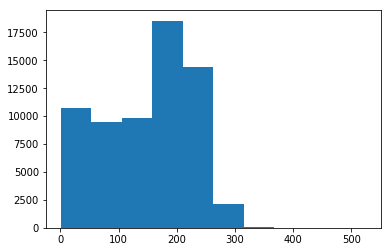

In [7]:
plt.hist([len(letter_list) for letter_list in sample_letters]);

In [ ]:
short_indices = [i for (i,mfe) in enumerate(sample_mfes) if mfe.shape[0] <= max_mfe_len and len(sample_letters[i])<=max_char_len and len(sample_phonemes[i])<=max_phon_len]
short_mfes = [sample_mfes[i] for i in short_indices]
short_phonemes =[sample_phonemes[i] for i in short_indices]
short_letters = [sample_letters[i] for i in short_indices]
short_ids = [sample_ids[i] for i in short_indices]
len(short_letters)


In [13]:
K = (len(short_indices) / 10) * 10
short_letters_five = short_letters[:K]
short_mfes_five = short_mfes[:K]
short_indices_five = short_indices[:K]
short_ids_five = short_ids[:K]
short_phonemes_five = short_phonemes[:K]
len(short_letters_five)

65040

In [ ]:
alphabet = dict(zip("abcdefghijklmnopqrstuvwxyz ", range(27)))


In [44]:

from keras.preprocessing.sequence import pad_sequences



# del sample_mfes, sample_phonemes
n = len(short_letters_five)

chunks = []

# Each chunk contains a tuple, where each tuple contains a list of one-fifth the size of the whole data
for i in range(5):
    
    
    start = i*n/5
    end = (i+1)*n/5
    print "Starting chunk", i, " with start and end points:", start, ",", end
    mfes_chunk = short_mfes_five[start:end]
    letters_chunk = short_letters_five[start:end]
    ids_chunk = short_ids_five[start:end]
    chunk = {"mfes":mfes_chunk, 
             "letters":letters_chunk, 
            "ids":ids_chunk,
            "input_lengths": np.asarray([mfe.shape[0] for mfe in mfes_chunk]),
            "label_lengths": np.asarray([len(sentence) for sentence in letters_chunk]),
            "coded_letters": [[alphabet[letter] for letter in sentence] for sentence in letters_chunk]}
    chunks.append(chunk)
    
    # Should I pad at the beginning or the end? Probably the end
    # Pad with value 69 because the phonemes are indexed 0 to 68
    print "Creating padded labels..."
    y_chunk = keras.preprocessing.sequence.pad_sequences(chunk["coded_letters"], maxlen=max_phrase_len, dtype='int32',
        padding='post', truncating='post', value=-1)
    print "Creating padded mfes..."
    X_chunk = keras.preprocessing.sequence.pad_sequences(chunk["mfes"], maxlen=max_mfe_len, dtype='float32',
    padding='post', truncating='post', value=0.)
    print "Saving everything.."
    np.savez('Libri_data_lib/data_padded_'+str(i), ids_chunk, X_chunk, chunk["input_lengths"], y_chunk, chunk["label_lengths"])
    print "Done with this chunk!"

Starting chunk 0  with start and end points: 0 ,  13008
Creating padded labels...
Creating padded mfes...
Saving everything..
Done with this chunk!
Starting chunk 1  with start and end points: 13008 ,  26016
Creating padded labels...
Creating padded mfes...
Saving everything..
Done with this chunk!
Starting chunk 2  with start and end points: 26016 ,  39024
Creating padded labels...
Creating padded mfes...
Saving everything..
Done with this chunk!
Starting chunk 3  with start and end points: 39024 ,  52032
Creating padded labels...
Creating padded mfes...
Saving everything..
Done with this chunk!
Starting chunk 4  with start and end points: 52032 ,  65040
Creating padded labels...
Creating padded mfes...
Saving everything..
Done with this chunk!


In [36]:
"".join(chunks[0]["letters"][0])

'not compatible with individuality i am of course not undertaking here to discuss the merits of socialism my purpose is only to point out that those who are hostile to socialism must cherish liberty'

In [38]:
print chunks[0]["coded letters"][0]

[13, 14, 19, 26, 2, 14, 12, 15, 0, 19, 8, 1, 11, 4, 26, 22, 8, 19, 7, 26, 8, 13, 3, 8, 21, 8, 3, 20, 0, 11, 8, 19, 24, 26, 8, 26, 0, 12, 26, 14, 5, 26, 2, 14, 20, 17, 18, 4, 26, 13, 14, 19, 26, 20, 13, 3, 4, 17, 19, 0, 10, 8, 13, 6, 26, 7, 4, 17, 4, 26, 19, 14, 26, 3, 8, 18, 2, 20, 18, 18, 26, 19, 7, 4, 26, 12, 4, 17, 8, 19, 18, 26, 14, 5, 26, 18, 14, 2, 8, 0, 11, 8, 18, 12, 26, 12, 24, 26, 15, 20, 17, 15, 14, 18, 4, 26, 8, 18, 26, 14, 13, 11, 24, 26, 19, 14, 26, 15, 14, 8, 13, 19, 26, 14, 20, 19, 26, 19, 7, 0, 19, 26, 19, 7, 14, 18, 4, 26, 22, 7, 14, 26, 0, 17, 4, 26, 7, 14, 18, 19, 8, 11, 4, 26, 19, 14, 26, 18, 14, 2, 8, 0, 11, 8, 18, 12, 26, 12, 20, 18, 19, 26, 2, 7, 4, 17, 8, 18, 7, 26, 11, 8, 1, 4, 17, 19, 24]
